# ESTIMATIVA ESPACIAL PARA ANÁLISE DE DADOS DE SUPERFÍCIE EM PYTHON


Este notebook tem como objetivo reproduzir análises estatísticas clássicas e ferramentas geoestatísticas a partir de um banco de dados de sondagem fictício, o qual traz informações de teores de duas variáveis: V e U. Através das ferramentas variograma e krigagem, deseja-se estimar os teores da área em que não houve sondagem.

# BIBLIOTECAS

O desenvolvimento desse workflow tem como base duas bibliotecas principais: GeostatsPy, desenvolvida por Michael Pyrcz,  professor associado da universidade do Texas em Austin, e GSLIB.

In [1]:
#IMPORTANDO BIBLIOTECAS NECESSÁRIAS

import geostatspy.GSLIB as GSLIB 
import geostatspy.geostats as geostats
import itertools
import io
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm 
from sklearn import preprocessing
from ipywidgets import interactive                      
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
import wget
import pyLPM

In [2]:
# PUXANDO O BANCO DE DADOS DE UM ARQUIVO XLSX PARA O NOTEBOOK

dadosgeo = pd.read_excel(r'C:\Users\thall\Documents\Material do Excel\Data Science Python\Tabela_Geoestatística.xlsx')
dadosgeo = dadosgeo[['X', 'Y', 'V(%)', 'U(ppm)']]
dadosgeo['U(ppm)'].replace(-99, np.nan, inplace = True)
dadosgeo['Id'] = dadosgeo.index
dadosgeo.head()

X   Y   V(%)  U(ppm)  Id
0  11   8  0.000     NaN   0
1   8  30  0.000     NaN   1
2   9  48  2.244     NaN   2
3   8  69  4.344     NaN   3
4   9  90  4.121     NaN   4

In [3]:
#VISUALIZAÇÃO DOS DADOS À PARTIR DA SONDAGEM DE OURO 

dados_uv = dadosgeo[195:]
dados_uv.head()

X    Y   V(%)  U(ppm)   Id
195   70  121  0.307     0.0  195
196   79  149  0.441     0.0  196
197   81  200  0.000     0.0  197
198  100   48  0.487     0.0  198
199  100   60  0.000     0.0  199

# ANÁLISE ESTATÍSTICA

A Estatística Univariada inclui todos os métodos de Estatística Descritiva que permitem a análise de cada variável separadamente e também métodos de Estatística Inferencial para determinada variável, podendo esta ser medida para uma ou mais amostras independentes. A análise de variância simples (e o teste "t", em particular) é o exemplo típico de um método de Estatística Univariada (Reis, 1997), pois a palavra «univariada» implica que há uma só variável dependente (Burns, 2000; M. Hill & A. Hill, 2000; Thomas & Nelson, 1996). Sin.: Estatística Univariável (Dorsch et al., 2001); Estatística a uma dimensão (Dagnelie, n.d.).

A Estatística Bivariada inclui métodos de análise de duas variáveis, podendo ser ou não estabelecida uma relação de causa/efeito entre elas. São exemplos típicos de métodos de análise bivariada o teste para a independência de duas variáveis (vulgarmente conhecido por teste do c 2) e o estudo da relação linear entre duas variáveis, quer através dos coeficientes de correlação linear de Pearson ou Spearman, quer do modelo clássico de regressão linear simples (Reis, 1997). Sin.: Estatística Bivariável (Dorsch et al., 2001); Estatística a duas dimensões (Dagnelie, n.d.).

In [4]:
#ANÁLISE ESTATÍSTICA DAS VARIÁVEIS PRESENTES EM NOSSO BANCO DE DADOS

colunas = dadosgeo.columns
colunas = list(colunas)
coef_var = []
for i in colunas:
    dp = dadosgeo[i].std()
    media = dadosgeo[i].mean()
    cv = (dp/media)*100
    coef_var.append(cv)
    
dados_estatísticos = dadosgeo.describe().transpose()
dados_estatísticos['cv(%)'] = coef_var
dados_estatísticos

count        mean         std  min        25%       50%        75%  \
X       470.0  111.089362   70.894682  8.0   51.00000   89.0000  170.00000   
Y       470.0  141.221277   77.968954  8.0   80.00000  139.5000  208.00000   
V(%)    470.0    4.352987    2.998823  0.0    1.84600    4.2400    6.40850   
U(ppm)  275.0    0.604081    0.767406  0.0    0.08215    0.3193    0.84455   
Id      470.0  234.500000  135.821574  0.0  117.25000  234.5000  351.75000   

             max       cv(%)  
X       251.0000   63.817706  
Y       291.0000   55.210486  
V(%)     15.2810   68.891151  
U(ppm)    5.1901  127.036855  
Id      469.0000   57.919648

Um histograma consiste em um gráfico de barras que demonstra uma distribuição de frequências, onde a base de cada uma das barras representa uma classe, e a altura a quantidade ou frequência absoluta com que o valor da classe ocorre. Ao mesmo tempo, pode ser utilizado como um indicador de dispersão de processos. Tem como objetivo ilustrar como uma determinada amostra de dados ou população está distribuída, dispondo as informações de modo a facilitar a visualização da distribuição dos dados. Ao mesmo tempo, ressalta a localização do valor central e da distribuição dos dados em torno deste valor central. 

Possui dois eixos com funções diferentes, onde o eixo horizontal é dividido em pequenos intervalos, demonstrando valores assumidos pela variável de interesse. Já o eixo vertical é proporcional à frequência de observações da amostra onde os valores pertencem aquela classe ou intervalo.

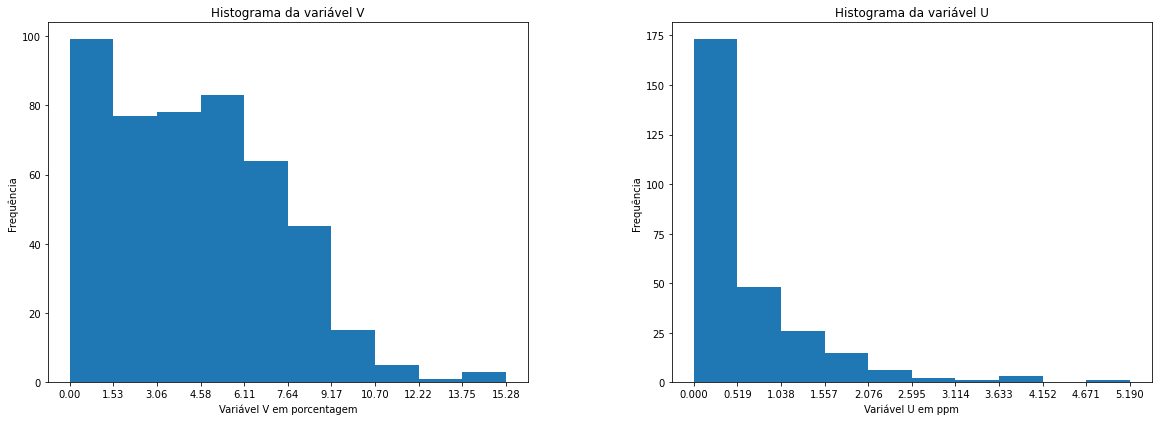

In [5]:
#HISTOGRAMAS DAS VARIÁVEIS V E U DO NOSSO BANCO DE DADOS

plt.subplot(131)
count, bin_edges = np.histogram(dadosgeo['V(%)'])
dadosgeo['V(%)'].plot(kind='hist', figsize=(8,5), xticks=bin_edges)
plt.title('Histograma da variável V')
plt.ylabel('Frequência') 
plt.xlabel('Variável V em porcentagem') 

plt.subplot(132)
count, bin_edges = np.histogram(dados_uv['U(ppm)'])
dados_uv['U(ppm)'].plot(kind='hist', figsize=(8,5), xticks=bin_edges)
plt.title('Histograma da variável U')
plt.ylabel('Frequência') 
plt.xlabel('Variável U em ppm') 

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0, wspace=0.3, hspace=0.3)
plt.show()

In [6]:
#DEFINIÇÃO DAS VARIÁVEIS CONTENDO OS VALORES DE CADA COLUNA

X_uv = dados_uv['X'].values
Y_uv = dados_uv['Y'].values
V_uv = dados_uv['V(%)'].values
U_uv = dados_uv['U(ppm)'].values

X_dg = dadosgeo['X'].values
Y_dg = dadosgeo['Y'].values
V_dg = dadosgeo['V(%)'].values

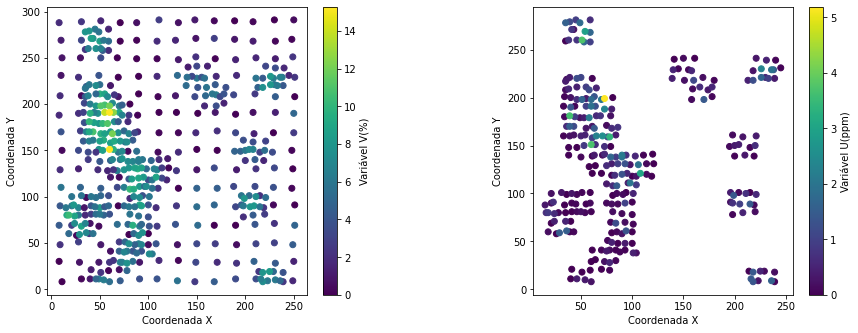

In [7]:
#VISUALIZAÇÃO DE TOPO DA REGIÃO ANALISADA ATRAVÉS DO SCATTER PLOT DOS VALORES DE COORDENADAS X E Y

plt.subplot(131)
plt.scatter(X_dg, Y_dg, c=V_dg, cmap = 'viridis')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.colorbar().set_label('Variável V(%)')

plt.subplot(132)
plt.scatter(X_uv, Y_uv, c=U_uv, cmap = 'viridis')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.colorbar().set_label('Variável U(ppm)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0, wspace=0.5, hspace=0.3)
plt.show()

Os gráficos de dispersão ou Scatter plot são representações gráficas do relacionamento entre duas variáveis numéricas. O Scatter plot utiliza pontos para representar essa relação, cada ponto representa o valor de uma variável no eixo horizontal e o valor de outra variável no eixo vertical.

Descrito por Francis Galton, o Scatter plot é usado para verificar se existe uma relação entre causa e efeito entre duas variáveis numéricas. Isso não significa que uma variável causa efeito na outra, mas apenas se existe uma relação e qual intensidade entre essa relação. A relação entre duas variáveis pode ser positiva, negativa ou neutra, linear ou não linear.

O gráfico de dispersão não mostra apenas o valor individualmente, mas mostra os dados como um todo. Sendo útil para identificar outro padrões nos dados, como outlier (pontos extremos) ou possíveis grupos entre os dados.

Coeficientes:  [[0.15113006]]
Interceptação:  [-0.22523935]


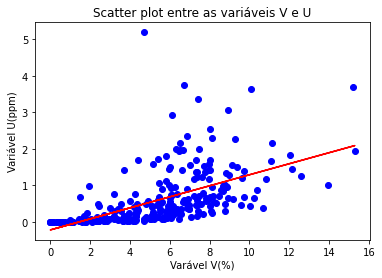

In [8]:
#SCATTER PLOT UTILIZANDO AS VARIÁVEIS V E U

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(dados_uv[['V(%)']])
train_y = np.asanyarray(dados_uv[['U(ppm)']])
regr.fit(train_x, train_y)
print ('Coeficientes: ', regr.coef_)
print ('Interceptação: ',regr.intercept_)
plt.scatter(V_uv, U_uv,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.title('Scatter plot entre as variáveis V e U')
plt.xlabel("Varável V(%)")
plt.ylabel("Variável U(ppm)")
plt.show()

In [9]:
geostats.nscore 

<function geostatspy.geostats.nscore(df, vcol, wcol=None, ismooth=False, dfsmooth=None, smcol=0, smwcol=0)>

# VARIOGRAMA

O variograma é uma ferramenta básica de suporte às técnicas de krigeagem, que permite representar quantitativamente a variação de um fenômeno regionalizado no espaço (Huijbregts, 1975). Considere duas variáveis regionalizadas, X e Y, onde X = Z(x) e Y = Z(x+h). Neste caso, referem-se ao mesmo atributo (por exemplo, o teor de zinco no solo) medido em duas posições diferentes, conforme ilustra a Figura 5.2, onde

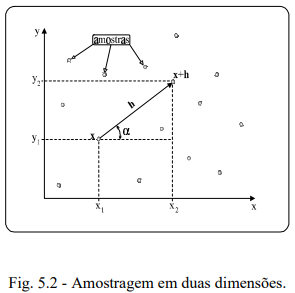

x denota uma posição em duas dimensões, com componentes (xi , yi), e h um vetor distância (módulo e direção) que separa os pontos.

O nível de dependência entre essas duas variáveis regionalizadas, X e Y, é representado pelo variograma, 2g(h), o qual é definido como a esperança matemática do quadrado da diferença entre os valores de pontos no espaço, separados pelo vetor distância h, isto é,

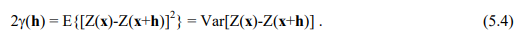

Através de uma amostra z(xi), i=1, 2, ..., n, o variograma pode ser estimado por

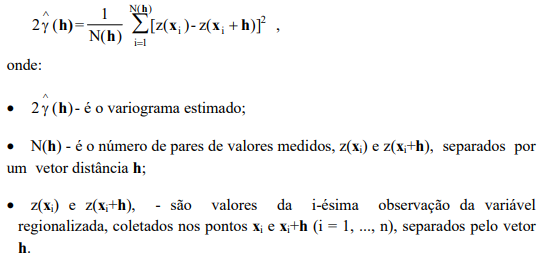

PARÂMETROS DO SEMIVARIOGRAMA

    
A Figura 5.3 ilustra um semivariograma experimental com características muito próximas do ideal. O seu padrão representa o que, intuitivamente, se espera de dados de campo, isto é, que as diferenças {Z(xi) - Z(xi + h)} decresçam à medida que h, a
distância que os separa decresce. É esperado que observações mais próximas geograficamente tenham um comportamento mais semelhante entre si do que aquelas separadas por maiores distâncias. Desta maneira, é esperado que g(h) aumente com a distância h.

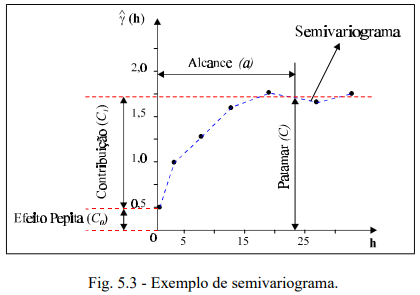

Os parâmetros do semivariograma podem ser compreendidos abaixo:

· Alcance (a): distância dentro da qual as amostras apresentam-se correlacionadas espacialmente. Na Figura 5.3, o alcance ocorre próximo de 25m.

· Patamar (C): é o valor do semivariograma correspondente a seu alcance (a). Deste ponto em diante, considera-se que não existe mais dependência espacial entre as amostras, porque a variância da diferença entre pares de amostra (Var[Z(x) - Z(x+h)]) torna-se invariante com a distância.

· Efeito Pepita (C0): idealmente, g(0)=0. Entretanto, na prática, à medida que h tende para 0 (zero), g(h) se aproxima de um valor positivo chamado Efeito Pepita (C0), que revela a descontinuidade do semivariograma para distânciasmenores do que a menor distância entre as amostras. Parte desta descontinuidade pode ser também devida a erros de medição (Isaaks eSrivastava, 1989), mas é impossível quantificar se a maior contribuição provém dos erros de medição ou da variabilidade de pequena escala não captada pel amostragem.

· Contribuição (C1): é a diferença entre o patamar (C) e o Efeito Pepita (Co).

In [10]:
#CRIAÇÃO DE UM SEMIVARIOGRAMA INTERATIVO

l = widgets.Text(value='                                                                                           Demonstração de um semivariograma interativo ',layout=Layout(width='950px', height='30px'))
lag = widgets.FloatSlider(min = 10, max = 100, value = 10, step = 10, description = 'Lag',orientation='vertical',layout=Layout(width='90px', height='200px'))
lag.style.handle_color = 'gray'

lag_tol = widgets.FloatSlider(min = 5, max = 100, value = 5, step = 10, description = 'Tolerância dos lags',orientation='vertical',layout=Layout(width='90px', height='200px'))
lag_tol.style.handle_color = 'gray'

nlag = widgets.IntSlider(min = 1, max = 100, value = 15, step = 1, description = 'Número de lags',orientation='vertical',layout=Layout(width='90px', height='200px'))
nlag.style.handle_color = 'gray'

azi = widgets.FloatSlider(min = 0, max = 180, value = 0, step = 22.5, description = 'Azimuth',orientation='vertical',layout=Layout(width='90px', height='200px'))
azi.style.handle_color = 'gray'

azi_tol = widgets.FloatSlider(min = 11.25, max = 90, value = 11.25, step = 5, description = 'Tolerancia do azimuth',orientation='vertical',layout=Layout(width='120px', height='200px'))
azi_tol.style.handle_color = 'gray'

bandwidth = widgets.FloatSlider(min = 0, max = 100, value = 15, step = 5, description = 'Bandwidth',orientation='vertical',layout=Layout(width='90px', height='200px'))
azi_tol.style.handle_color = 'gray'

ui1 = widgets.HBox([lag,lag_tol,nlag,azi,azi_tol,bandwidth],) # formatação básica de widget    
ui = widgets.VBox([l,ui1],)

def f_make(lag,lag_tol,nlag,azi,azi_tol,bandwidth):     # função para obter parâmetros, calcular e traçar semivariograma

    tmin = -9999.9; tmax = 9999.9
    lags, gammas, npps = geostats.gamv(dadosgeo,"X","Y","V(%)",tmin,tmax,lag,lag_tol,nlag,azi,azi_tol,bandwidth,isill=0.0)
    
    plt.subplot(111)                                    # traçar variograma experimental
    plt.scatter(lags,gammas,color = 'black',s = npps*0.1,label = 'Azimuth ' +str(azi))
    plt.plot([0,2000],[9.0,9.0],color = 'black')
    plt.xlabel(r'Distâcia dos lags $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Variograma direcional da variável V(%) - Azi ' + str(azi))
    plt.xlim([0,150]); plt.ylim([0,12])
    plt.grid(True)
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.3, hspace=0.3)
    plt.show()
    
interactive_plot = widgets.interactive_output(f_make, {'lag':lag,'lag_tol':lag_tol,'nlag':nlag,'azi':azi,'azi_tol':azi_tol,'bandwidth':bandwidth})
interactive_plot.clear_output(wait = True)   

In [11]:
display(ui, interactive_plot) 

Output()

c:\users\thall\appdata\local\programs\python\python38\lib\site-packages\geostatspy\GSLIB.py:462: MatplotlibDeprecationWarning:

The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.



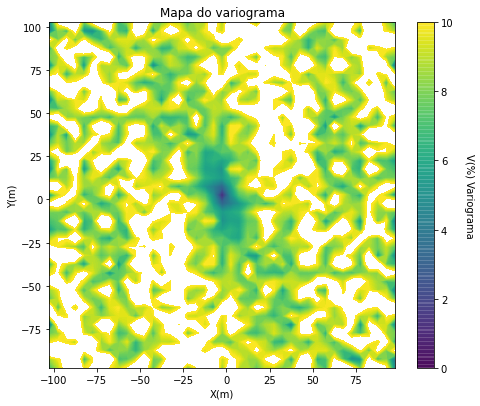

A forma do resultado é (41, 41)


In [12]:
vmap, npmap = geostats.varmapv(dadosgeo,'X','Y','V(%)',tmin=-999,tmax=999,nxlag=20,nylag=20,dxlag=5,dylag=5,minnp=1,isill=0)

plt.subplot(111)
GSLIB.pixelplt_st(vmap,-102.5,102.5,-102.5,102.5,5.0,0,10,'Mapa do variograma','X(m)','Y(m)','V(%) Variograma',cmap='viridis')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print('A forma do resultado é ' + str(vmap.shape))

# <font color='red'>NA CÉLULA ABAIXO SERÁ SOLICITADA A INSERÇÃO DOS VALORES DOS PARÂMETROS DE EXIBIÇÃO DOS VARIOGRAMAS ! </font>

In [13]:
valor_lag_dist = float(input("Digite a distância entre os lags: "))
valor_lag_tol = float(input("Digite a tolerância de busca dos lags: "))
valor_nlag = int(input("Digite o número de lags: "))
valor_atol = float(input("Digite a tolerância de busca por azimute: "))
valor_bandh = float(input("Digite a largura de banda para busca de amostras: "))
azi_0 = float(input("Digite a primeira direção de azimute para busca de amostras: "))
azi_1 = float(input("Digite a segunda direção de azimute para busca de amostras: "))
azi_2 = float(input("Digite a terceira direção de azimute para busca de amostras: "))
azi_3 = float(input("Digite a quarta direção de azimute para busca de amostras: "))
azi_4 = float(input("Digite a quinta direção de azimute para busca de amostras: "))
azi_5 = float(input("Digite a sexta direção de azimute para busca de amostras: "))
azi_6 = float(input("Digite a sétima direção de azimute para busca de amostras: "))
azi_7 = float(input("Digite a oitava direção de azimute para busca de amostras: "))

Digite a distância entre os lags: 10
Digite a tolerância de busca dos lags: 5
Digite o número de lags: 15
Digite a tolerância de busca por azimute: 22.5
Digite a largura de banda para busca de amostras: 15
Digite a primeira direção de azimute para busca de amostras: 0
Digite a segunda direção de azimute para busca de amostras: 22.5
Digite a terceira direção de azimute para busca de amostras: 45
Digite a quarta direção de azimute para busca de amostras: 67.5
Digite a quinta direção de azimute para busca de amostras: 90
Digite a sexta direção de azimute para busca de amostras: 112.5
Digite a sétima direção de azimute para busca de amostras: 135
Digite a oitava direção de azimute para busca de amostras: 157.5


In [14]:
tmin = -9999.; tmax = 9999.                             # LIMITES DE CORTE DA REGIÃO
lag_dist = valor_lag_dist; lag_tol = valor_lag_tol; nlag = valor_nlag;              # PARÂMETROS PARA VISUALIZAÇÃO PREVIAMENTE DEFINIDOS
bandh = valor_bandh; atol = valor_atol                                 # LARGURA DE BANDA HORIZONTAL
isill = 0                                               # VALORES NORMALIZADOS = 1; NÃO NORMALIZADOS = 0
azi_mat = [azi_0,azi_1,azi_2,azi_3,azi_4,azi_5,azi_6,azi_7]           # DIREÇÕES DE AZIMUTE A SEREM CONSIDERADAS

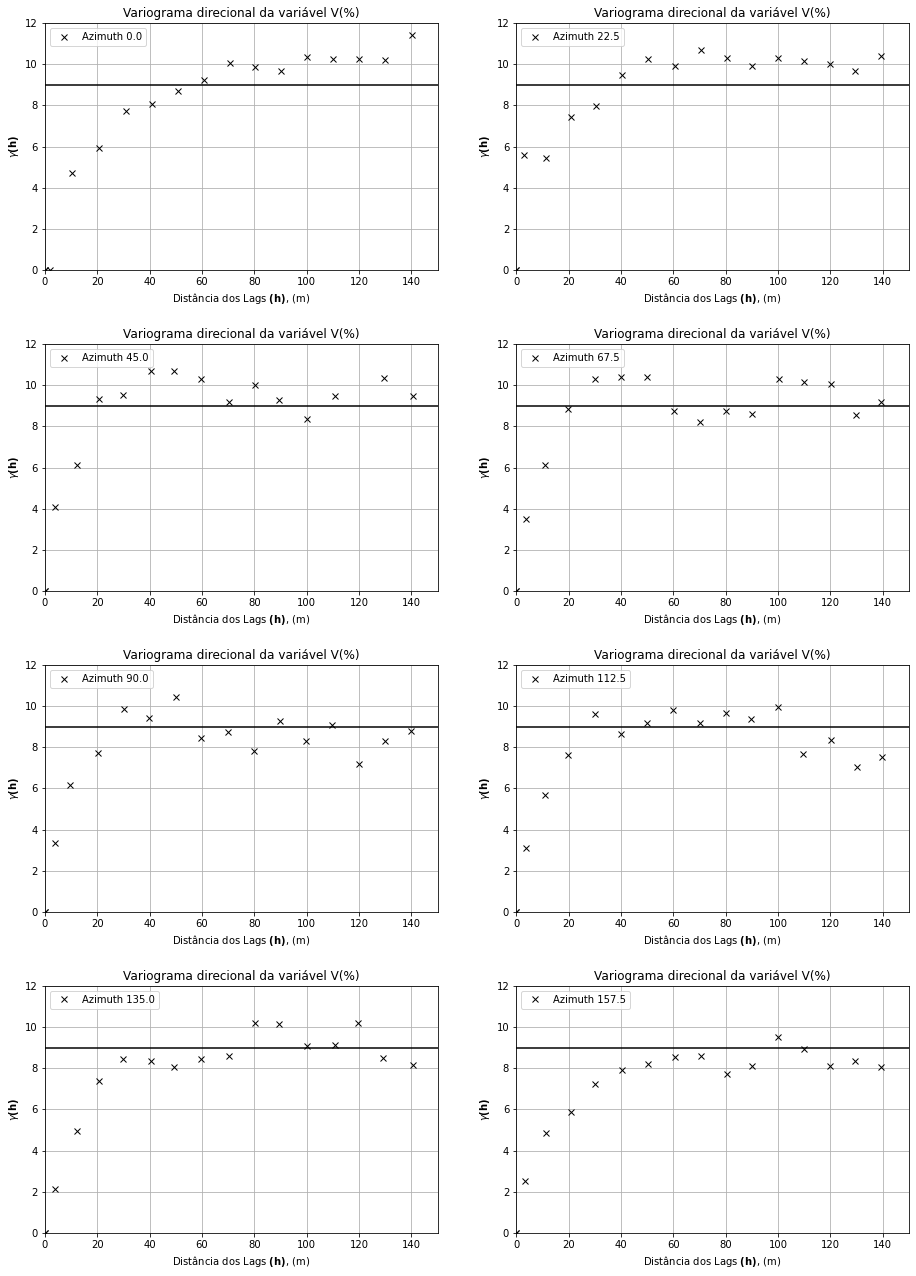

In [15]:
# CRIAÇÃO DE MATRIZES PARA ARMAZENAR OS RESULTADOS E REPRODUZIR DIFERENTES SEMIVARIOGRAMAS
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Faça um loop em todas as direções
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(dadosgeo,"X","Y","V(%)",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,2000],[9.0,9.0],color = 'black')
    plt.xlabel(r'Distância dos Lags $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Variograma direcional da variável V(%)')
    plt.xlim([0,150])
    plt.ylim([0,12])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=4.2, wspace=0.2, hspace=0.3)
plt.show()

# <font color='red'>ABAIXO SERÃO SOLICITADOS OS VARIOGRAMAS DE DIREÇÃO PRINCIPAL E SECUNDÁRIA, ONDE:
    1- Os variogramas plotados acima seguem a ordem de 0 a 7
    2- Por exemplo: Se você quiser se referir ao segundo variograma plotado, digite o número 1
    3- A diferença de azimutes entre o variograma de direção principal e o de direção secundária DEVE ser igual a 90°

In [16]:
valor_imajor = int(input("Digite o variograma que apresenta direção principal: "))
valor_iminor = int(input("Digite o variograma que apresenta direção secundária: "))

Digite o variograma que apresenta direção principal: 7
Digite o variograma que apresenta direção secundária: 3


A direção principal é 157.5 azimuth.
A direção secundária é 67.5 azimuth.


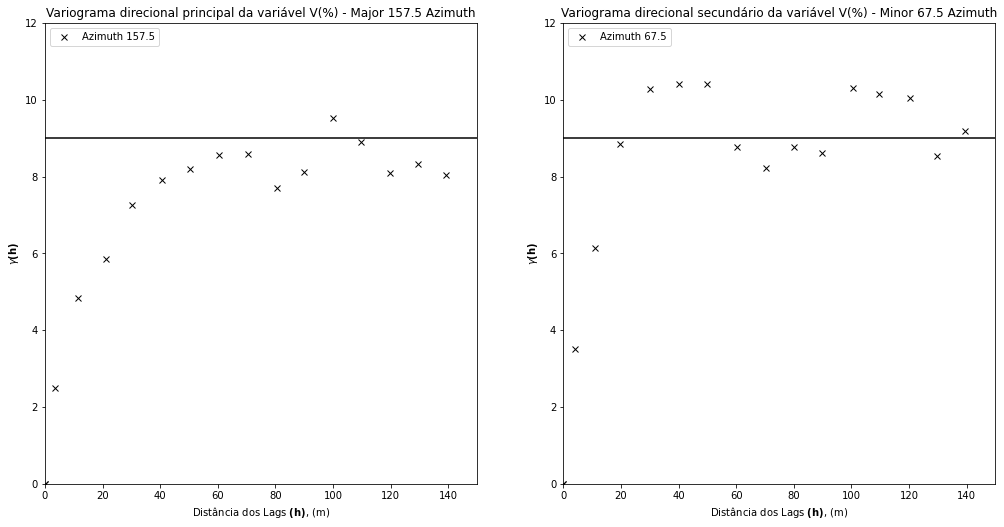

In [17]:
# SELEÇÃO DOS VARIOGRAMAS PRINCIPAL (MAIOR RELAÇÃO ENTRE PONTOS) E SECUNDÁRIO (MENOR RELAÇÃO ENTRE PONTOS)
imajor = valor_imajor
iminor = valor_iminor

print('A direção principal é ' + str(azi_mat[imajor]) + ' azimuth.')
print('A direção secundária é ' + str(azi_mat[iminor]) + ' azimuth.')

if not abs(azi_mat[imajor] - azi_mat[iminor]) == 90.0:
    print('As direções principal e secundária devem ser perpedicular entre si.')
    sys.exit()

plt.subplot(1,2,1)
plt.plot(lag[imajor,:],gamma[imajor,:],'x',color = 'black',label = 'Azimuth ' + str(azi_mat[imajor]))
plt.plot([0,2000],[9.0,9.0],color = 'black')
plt.xlabel(r'Distância dos Lags $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma direcional principal da variável V(%) - Major ' + str(azi_mat[imajor]) + ' Azimuth')
plt.xlim([0,150])
plt.ylim([0,12])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[iminor,:],gamma[iminor,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iminor]))
plt.plot([0,2000],[9.0,9.0],color = 'black')
plt.xlabel(r'Distância dos Lags $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma direcional secundário da variável V(%) - Minor ' + str(azi_mat[iminor]) + ' Azimuth')
plt.xlim([0,150])
plt.ylim([0,12])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

In [18]:
# MODELAGEM INTERATIVA DA CURVA DE REGRESSÃO DOS SEMIVARIOGRAMA PRINCIPAL E SECUNDÁRIO

l = widgets.Text(value='                              MODELAGEM DE VARIOGRAMA',layout=Layout(width='950px', height='30px'))
nug = widgets.FloatSlider(min = 0, max = 3.0, value = 2.2, step = 0.1, description = 'nug',orientation='vertical',layout=Layout(width='90px', height='200px'))
nug.style.handle_color = 'gray'
it1 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
    description='Type1:',disabled=False,layout=Layout(width='200px', height='30px'))
c1 = widgets.FloatSlider(min=0.0, max = 10.0, value = 6.3, step = 0.1, description = 'c1',orientation='vertical',layout=Layout(width='90px', height='200px'))
c1.style.handle_color = 'blue'
hmaj1 = widgets.FloatSlider(min=0.01, max = 100.0, value = 70.00, step = 1.0, description = 'hmaj1',orientation='vertical',layout=Layout(width='90px', height='200px'))
hmaj1.style.handle_color = 'red'
hmin1 = widgets.FloatSlider(min = 0.01, max = 100.0, value = 42.00, step = 1.0, description = 'hmin1',orientation='vertical',layout=Layout(width='90px', height='200px'))
hmin1.style.handle_color = 'green'

it2 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
    description='Type2:',disabled=False,layout=Layout(width='200px', height='30px'))
c2 = widgets.FloatSlider(min=0.0, max = 10.0, value = 0.5, step = 0.1, description = 'c2',orientation='vertical',layout=Layout(width='90px', height='200px'))
c2.style.handle_color = 'blue'
hmaj2 = widgets.FloatSlider(min=0.01, max = 100.0, value = 100.00, step = 1.0, description = 'hmaj2',orientation='vertical',layout=Layout(width='90px', height='200px'))
hmaj2.style.handle_color = 'red'
hmin2 = widgets.FloatSlider(min = 0.01, max = 100.0, value = 45.00, step = 1.0, description = 'hmin2',orientation='vertical',layout=Layout(width='90px', height='200px'))
hmin2.style.handle_color = 'green'

ui1 = widgets.HBox([nug,it1,c1,hmaj1,hmin1,it2,c2,hmaj2,hmin2],)                   # formatação básica de widget 
#ui2 = widgets.HBox([it2,c2,hmaj2,hmin2],)                   # formatação básica de widget   
ui = widgets.VBox([l,ui1],)

def convert_type(it):
    if it == 'Spherical': 
        return 1
    elif it == 'Exponential':
        return 2
    else: 
        return 3

def f_make(nug,it1,c1, hmaj1, hmin1, it2, c2, hmaj2, hmin2):                       # função para obter parâmetros, fazer amostra e plotar
    text_trap = io.StringIO()
    sys.stdout = text_trap
    
    it1 = convert_type(it1); it2 = convert_type(it2)
    if c2 > 0.0:
        nst = 2
    else:
        nst = 1
    
    vario = GSLIB.make_variogram(nug,nst,it1,c1,azi_mat[imajor],hmaj1,hmin1,it2,c2,azi_mat[imajor],hmaj2,hmin2) 
    nlag = 160; xlag = 1;                                     
    index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi_mat[imajor],vario)   # projetar o modelo no azimute principal                                                  # project the model in the 135 azimuth
    index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,azi_mat[iminor],vario) # projetar o modelo no azimute secundário
    
    plt.subplot(2,2,1)
    plt.plot(lag[imajor,:],gamma[imajor,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[2]))
    plt.plot([0,2000],[9.0,9.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Variograma da direção principal  - Major ' + str(azi_mat[imajor]) + 'Azimuth')
    plt.xlim([0,150])
    plt.ylim([0,12])
    plt.legend(loc='upper left')
    
    plt.subplot(2,2,2)
    plt.plot(lag[iminor,:],gamma[iminor,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[6]))
    plt.plot([0,2000],[9.0,9.0],color = 'black')
    plt.plot(h_min,gam_min,color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Variograma da direção secundária  - Minor ' + str(azi_mat[iminor]) + 'Azimuth')
    plt.xlim([0,150])
    plt.ylim([0,12])
    plt.legend(loc='upper left')
    
    plt.subplot(2,2,3)
    plt.plot([0,2000],[9.0,9.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'black',label = 'Azimuth ' + str(azi_mat[imajor]))    
    plt.plot(h_min,gam_min,color = 'black',label = 'Azimuth ' + str(azi_mat[iminor]))
    deltas = [22.5, 45, 67.5]; 
    ndelta = len(deltas); hd = np.zeros(ndelta); gamd = np.zeros(ndelta);
    color=iter(cm.plasma(np.linspace(0,1,ndelta)))
    for delta in deltas:
        index,hd,gamd,cov,ro = geostats.vmodel(nlag,xlag,azi_mat[imajor]+delta,vario);
        c=next(color)
        plt.plot(hd,gamd,color = c,label = 'Azimuth ' + str(azi_mat[imajor]+delta))
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Interpolated Azimuth NSCORE Porosity Variogram Models')
    plt.xlim([0,700])
    plt.ylim([0,12])
    plt.legend(loc='upper left')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.5, wspace=0.3, hspace=0.3)
    plt.show()
    
# conecte a função para fazer as amostras e gerar os widgets    
interactive_plot = widgets.interactive_output(f_make, {'nug':nug, 'it1':it1,'c1':c1, 'hmaj1':hmaj1, 'hmin1':hmin1, 'it2':it2, 'c2':c2, 'hmaj2':hmaj2, 'hmin2':hmin2})
interactive_plot.clear_output(wait = True)               # reduza a oscilação atrasando a atualização do gráfico

In [19]:
import io
display(ui, interactive_plot)                            # exibir a plotagem interativa

Output()

# <font color='red'>ABAIXO SERÃO SOLICITADOS OS PARÂMETROS PARA PLOTAGEM DA CURVA REGRESSORA DO VARIOGRAMA CRIADO, ONDE:
        1- O tipo de estrutura a ser utilizado é referida pelo seu código (1, 2 ou 3).
        2- As estruturas são: Esférico (1), Exponencial (2) e Gaussiano (3).
        3- Por exemplo, se você quiser utilizar a estrutura Exponencial basta digitar o número 2 quando lhe for solicitado.

In [20]:
valor_nug = float(input("Digite o valor do efeito pepita: "))
valor_nst = int(input("Digite o número de estruturas a serem utilizadas no variograma (1 ou 2): "))
valor_it1 = int(input("Digite o valor referente ao tipo de estrutura para a primeira estrutura: "))
valor_cc1 = float(input("Digite o valor de contribuição da primeira estrutura: "))
valor_hmaj1 = float(input("Digite o valor de maior range para a estrutura 1: "))
valor_hmin1 = float(input("Digite o valor de menor range para a estrutura 2: "))
if valor_nst == 2:    
    valor_it2 = int(input("Digite o valor referente ao tipo de estrutura para a segunda estrutura: "))
    valor_cc2 = float(input("Digite o valor de contribuição da segunda estrutura: "))
    valor_hmaj2 = float(input("Digite o valor de maior range para a estrutura 2: "))
    valor_hmin2 = float(input("Digite o valor de menor range para a estrutura 2: "))

Digite o valor do efeito pepita: 2.2
Digite o número de estruturas a serem utilizadas no variograma (1 ou 2): 2
Digite o valor referente ao tipo de estrutura para a primeira estrutura: 1
Digite o valor de contribuição da primeira estrutura: 6.3
Digite o valor de maior range para a estrutura 1: 70
Digite o valor de menor range para a estrutura 2: 42
Digite o valor referente ao tipo de estrutura para a segunda estrutura: 1
Digite o valor de contribuição da segunda estrutura: 0.5
Digite o valor de maior range para a estrutura 2: 100
Digite o valor de menor range para a estrutura 2: 45


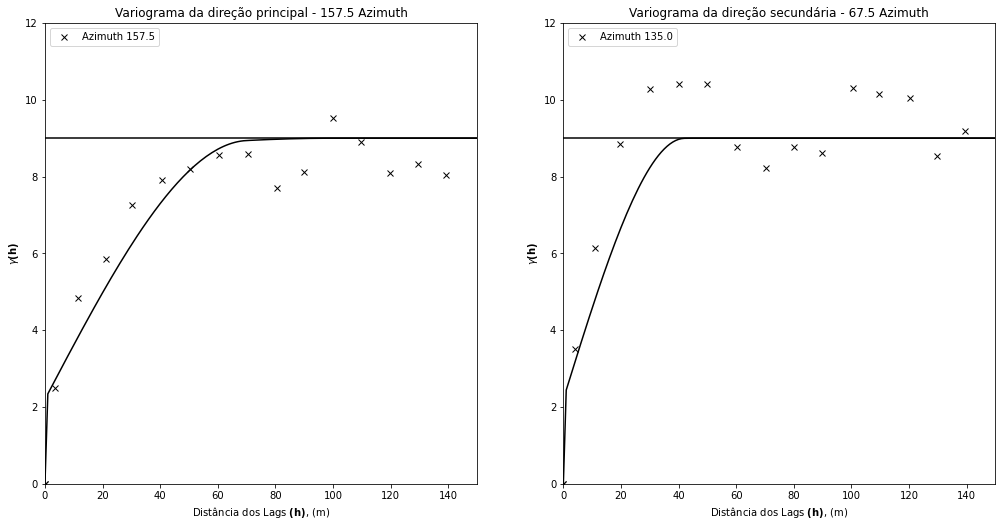

In [21]:
#DEFINIÇÃO DOS PARÂMETROS PARA REPRODUÇÃO DA MELHOR CURVA DE REGRESSÃO DOS PONTOS NOS VARIOGRAMAS PRINCIPAL E SECUDNDÁRIO

nug = valor_nug; nst = valor_nst   # NUG = EFEITO PEPITA ; NST = Nº DE ESTRUTURAS UTILIZADAS PARA DEFINIÇÃO DA CURVA DE REGRESSÃO (1 OU 2)

# IT = TIPO DE ESTRUTURA (1- ESFÉRICO; 2- EXPONENCIAL; 3- GAUSSIANO)
# CC = CONTRIBUIÇÃO DE CADA ESTRUTURA A QUAL SOMADA COM O EFEITO PEPITA RESULTA NO VALOR DO SILL
# AZI1 = AZI2 = AZIMUTE DO SEMIVARIOGRAMA PRINCIPAL
# HMAJ = INTERVALO PARA CADA ESTRUTURA NA DIREÇÃO PRINCIPAL
# HMIN =  INTERVALO PARA CADA ESTRUTURA NA DIREÇÃO SECUNDÁRIA

it1 = valor_it1; cc1 = valor_cc1; azi1 = azi_mat[imajor]; hmaj1 = valor_hmaj1; hmin1 = valor_hmin1
it2 = valor_it2; cc2 = valor_cc2; azi2 = azi_mat[imajor]; hmaj2 = valor_hmaj2; hmin2 = valor_hmin2

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # Função para criar o modelo do semivariograma
nlag = 160; xlag = 1;                                          
index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi_mat[imajor],vario)                                                     # project the model in the 135 azimuth
index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,azi_mat[iminor],vario)

plt.subplot(1,2,1)
plt.plot(lag[imajor,:],gamma[imajor,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[imajor]))
plt.plot([0,2000],[9.0,9.0],color = 'black')
plt.plot(h_maj,gam_maj,color = 'black')
plt.xlabel(r'Distância dos Lags $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma da direção principal - ' + str(azi_mat[imajor]) + ' Azimuth')
plt.xlim([0,150])
plt.ylim([0,12])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(lag[iminor,:],gamma[iminor,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[6]))
plt.plot([0,2000],[9.0,9.0],color = 'black')
plt.plot(h_min,gam_min,color = 'black')
plt.xlabel(r'Distância dos Lags $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Variograma da direção secundária - ' + str(azi_mat[iminor]) + ' Azimuth')
plt.xlim([0,150])
plt.ylim([0,12])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

In [22]:
if it1 == 1:
    tipo_1 = "Spherical"
if it1 == 2:
    tipo_1 = "Exponetial"
if it1 == 3:
    tipo_1 = "Gaussian"
if it2 == 1:
    tipo_2 = "Spherical"
if it2 == 2:
    tipo_2 = "Exponetial"
if it2 == 3:
    tipo_2 = "Gaussian"
            
exp_variogram = pyLPM.gammapy.experimental(
    dataset=dadosgeo,
    X='X',
    Y='Y',
    head='V(%)',
    tail='V(%)',
    type_c=['Variogram', 'Variogram'],
    nlags=[nlag,nlag],
    lagsize=[lag_dist,lag_tol],
    lineartol=[5,2.5],
    htol=[atol,atol],
    vtol=[atol,atol],
    hband=[bandh,bandh],
    vband=[bandh,bandh],
    azimuth=[azi_mat[imajor],azi_mat[iminor]],
    dip=[0,0],
    omni=[False,False],
    show_pairs=True,
    Z=None,
    choice=1.0,)
grid = pyLPM.utils.autogrid(
    x=dadosgeo.X,
    y=dadosgeo.Y,
    z=None,
    sx=1,
    sy=1,
    sz=1,
    buffer=0)
var_model = pyLPM.gammapy.modelling(
    experimental_dict=exp_variogram,
    rotation_max=166,
    rotation_med=0.,
    rotation_min=0.,
    nugget=nug,
    inverted=False,
    rangemax=[hmaj1,hmaj2],
    rangemed=[hmin1,hmin2],
    rangemin=[hmin1,hmin2],
    model=[tipo_1,tipo_2],
    contribution=[cc1,cc2],
    show_pairs=False,)
pyLPM.gslib.kt3d(
    df=dadosgeo,
    dh='Id',
    x='X',
    y='Y',
    z=None,
    var='V(%)',
    grid=grid,
    variogram=var_model,
    min_samples=4,
    max_samples=18,
    max_oct=3,
    search_radius=[150,50,0],
    search_ang = [166,0,0],
    discretization = [5,5,1],
    krig_type='OK',
    sk_mean = 0,
    tmin=-1.0e21,
    tmax=1.0e21,
    option='cross',
    debug_level=0,
    usewine=False)

# KRIGAGEM

A krigagem é um método geoestatístico estimador que leva em consideração as características espaciais de autocorrelação de variáveis regionalizadas. Nas variáveis regionalizadas deve existir uma certacontinuidade espacial, o que permite que os dados obtidos por amostragem de certos pontos possam ser usados para parametrizar a estimação de pontos onde o valor da variável seja desconhecido.

A krigagem se baseia na idéia de que se pode fazer inferências a partir de uma função aleatória Z(x), originando os pontos Z(x1), Z(x2), ..., Z(xn). A função Z(x) = m(x) + γ(h) + ε apresenta a média constante, a correlação espacial e o erro residual. A correlação espacial é dada pelo variograma. 

γ(h) = ½ var [ Z(x) – Z(x+h) ] = ½ E [ {Z(x) – Z(x+h)}2 ]; na prática:

γ(h) = ½ N(h) Σi[Z(xi) – Z(xi+h)]2,

onde N(h) é o número total de pares de observações separadas pela distância h. E a curva ajustada minimiza a variância dos erros. 

A krigagem produz a melhor estimativa linear não-viciada dos dados de um atributo em um local não amostrado, com a modelagem do variograma. “A krigagem ordinária é geralmente associada como B.L.U.E. (best linear unbiased estimator). A krigagem ordinária é ‘linear’ porque suas estimativas são combinações lineares ponderadas dos dados disponíveis; é ‘não-viciada’ porque busca o valor de erro ou resíduo médio igual a 0; e é ‘melhor’ porque minimiza a variância dos erros.” (Isaaks e Srivastava, 1989, p.278) 

O estimador da krigagem ordinária é baseado na fórmula da média ponderada, onde os ponderadores dependem da informação estrutural fornecida pelo variograma. Esta é a principal diferença em relação ao outros métodos de estimativa como, por exemplo, o inverso da distância. O valor da variável de interesse em um ponto não amostrado (xo) é calculado como combinação linear dos pontos de dados vizinhos (Z(xi), i=1,n), conforme segue:

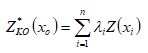

Os pesos da krigagem ordinária são calculados impondo-se duas condições de restrição. A primeira impõe que em média a diferença entre o valor calculado e real seja igual a zero:

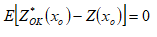

Desenvolvendo esta expressão, tem-se a condição de não viés:

A segunda condição de restrição impõe a minimização da variância do erro:
    
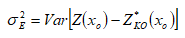

A minimização da variância do erro, sujeita à condição de não viés resulta no sistema de equações de krigagem, conforme Yamamoto e Landim (2013, p. 69-70). Os ponderadores da krigagem ordinária são calculados a partir da resolução desse sistema de equações.

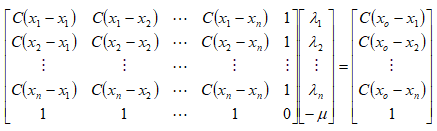

Os elementos são dados em termos de covariâncias e não em termos da função variograma, com a qual estamos acostumados. Geralmente, se obtém a função variograma, que pode ser transformada em função covariância usando a relação:

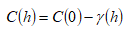

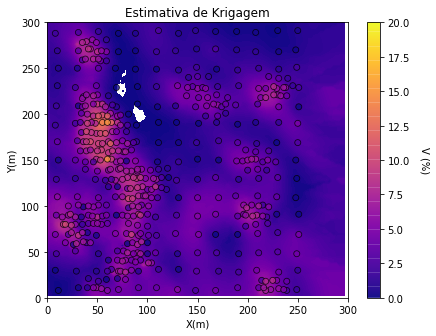

In [23]:
xmin = 0.0; xmax = 300.0               # intervalo de valores x
ymin = 0.0; ymax = 300.0               # intervalo de valores y

xsiz = 3; ysiz = 3                    # tamanho das células
nx = 100; ny = 100                      # Número de células
xmn = 5; ymn = 5                        # origem da grade, centro de localização da célula inferior esquerd

cmap = plt.cm.plasma                    # Cor do mapa
#GSLIB.locmap_st(dadosgeo,'X','Y','V(%)',xmin,xmax,ymin,ymax,0,1,'Scatter Plot da variável V','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 1                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

# DEFINIÇÃO DE PARÂMETROS PARA CÁLCULO DA KRIGAGEM

skmean = 1
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                              # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value
por_vario = GSLIB.make_variogram(nug=valor_nug,nst=valor_nst,it1=valor_it1,it2=valor_it2,cc1=valor_cc1,cc2=valor_cc2,azi1=azi_mat[imajor],azi2=azi_mat[imajor],hmaj1=valor_hmaj1,hmaj2=valor_hmaj2,hmin1=valor_hmin1,hmin2=valor_hmin2) # porosity variogram

# VISUALIZAÇÃO DA REGIÃO KRIGADA

por_kmap, por_vmap = geostats.kb2d(dadosgeo,'X','Y','V(%)',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,por_vario)

plt.subplot(221)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,20.00,dadosgeo,'X','Y','V(%)','Estimativa de Krigagem','X(m)','Y(m)','V (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()